In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image


In [2]:
SEED = 123

# HEIGHT, WIDTH = 248, 496
# HEIGHT, WIDTH = 256, 256
HEIGHT, WIDTH = 224, 224


---

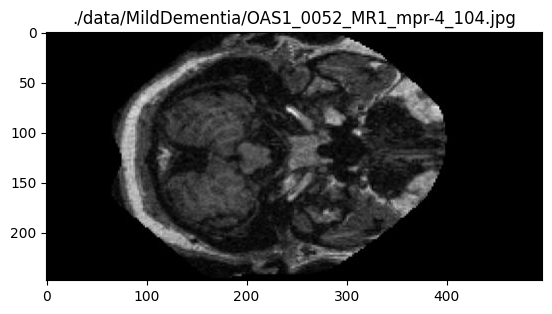

MildDementia
total 5002
ndim {3}
width {496}
height {248}
max 255



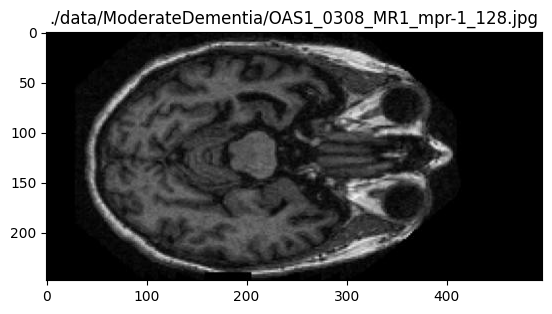

ModerateDementia
total 488
ndim {3}
width {496}
height {248}
max 255



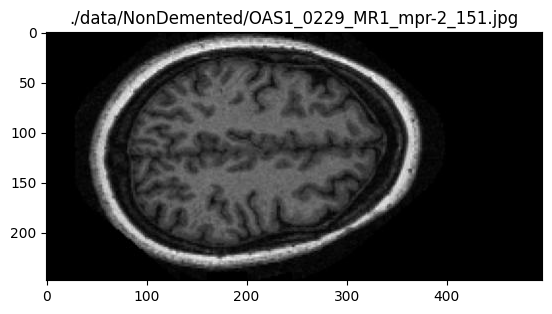

NonDemented
total 67222
ndim {3}
width {496}
height {248}
max 255



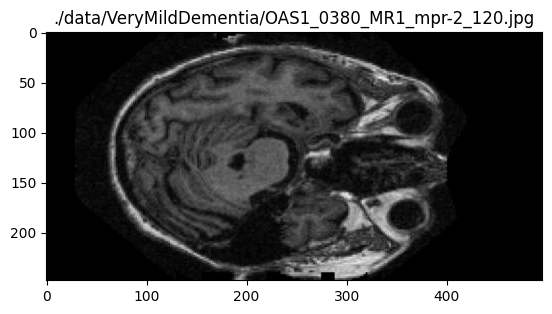

VeryMildDementia
total 13725
ndim {3}
width {496}
height {248}
max 255



In [3]:
data_dir = './data'
classes = ['MildDementia', 'ModerateDementia', 'NonDemented', 'VeryMildDementia']
img_paths, img_labs = [], []
lab_counts = {}

for cls in classes:
    dim, width, height, pix = [], [], [], []

    cls_path = os.path.join(data_dir, cls)
    for file_path in os.listdir(cls_path):
        if not file_path.endswith('.jpg'):
            continue
        file_path = os.path.join(cls_path, file_path)
        img_paths.append(file_path)
        img_labs.append(cls)
        
        with Image.open(file_path) as infile:
            img = np.asarray(infile)
        dim.append(img.ndim)
        width.append(img.shape[1])
        height.append(img.shape[0])
        pix.append(img.max())

    plt.figure()
    plt.imshow(img)
    plt.title(file_path)
    plt.show()

    lab_counts[cls] = len(dim)
    print(cls)
    print('total', len(dim))
    print('ndim', set(dim))
    print('width', set(width))
    print('height', set(height))
    print('max', max(pix))
    print()
    
del img, dim, width, height, pix

In [4]:
# Sample a subset of the data becuase I'm not made of money (or time)
df = pd.DataFrame({'filename': img_paths, 'class': img_labs})
df = pd.concat([
    df[df['class']=='ModerateDementia'],
    df[df['class']=='MildDementia'].sample(n=500, replace=False, random_state=SEED),
    df[df['class']=='VeryMildDementia'].sample(n=500, replace=False, random_state=SEED),
    df[df['class']=='NonDemented'].sample(n=500, replace=False, random_state=SEED),
]).sample(frac=1., replace=False, random_state=SEED)

In [131]:
df['class'].value_counts()[classes]

class
MildDementia        500
ModerateDementia    488
NonDemented         500
VeryMildDementia    500
Name: count, dtype: int64

In [5]:
df_train, df_test = train_test_split(
    df, test_size=300, shuffle=True, random_state=SEED, stratify=df['class']
)

In [6]:
df_train, df_val = train_test_split(
    df_train, test_size=300, shuffle=True, random_state=SEED, stratify=df_train['class']
)

In [7]:
print('train', len(df_train))
print('val', len(df_val))
print('test', len(df_test))

train 1388
val 300
test 300


In [8]:
df_train['weight'] = compute_sample_weight('balanced', y=df_train['class'])
# lab_counts_train = df_train['class'].value_counts()
# weights = np.array([lab_counts_train[c] for c in classes])
# weights = weights.sum() / (weights.size * weights)
# weights

In [9]:
init_kwargs = dict(
    data_format='channels_last',
    validation_split=0.,
    rescale=1/255,
    fill_mode='constant',
    cval=0.,
)
flow_kwargs = dict(
    target_size=(HEIGHT, WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)

train_datagen = ImageDataGenerator(
    rotation_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.,
    zoom_range=0.01,
    channel_shift_range=0.,
    horizontal_flip=False,
    vertical_flip=False,
    **init_kwargs
).flow_from_dataframe(df_train, weight_col='weight', **flow_kwargs)

val_datagen = ImageDataGenerator(
    **init_kwargs
).flow_from_dataframe(df_val, **flow_kwargs)

test_datagen = ImageDataGenerator(
    **init_kwargs
).flow_from_dataframe(df_test, **flow_kwargs)

Found 1388 validated image filenames belonging to 4 classes.
Found 300 validated image filenames belonging to 4 classes.
Found 300 validated image filenames belonging to 4 classes.


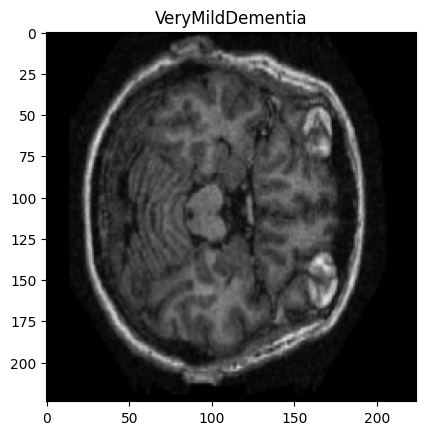

In [10]:
img, lab, wgt = next(iter(train_datagen))
plt.figure()
plt.imshow(img[0,:,:,:])
plt.title(classes[lab[0].argmax()])
plt.show()
del img, lab, wgt

---

In [15]:
# alzheimers_detection_model_5

x_in = layers.Input(shape=(HEIGHT, WIDTH, 3))

x = layers.Conv2D(16, (3, 3))(x_in)
x = layers.Activation('leaky_relu')(x)
x = layers.Conv2D(32, (2, 2))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(32, (3, 3))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.Conv2D(64, (2, 2))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, (3, 3))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.Conv2D(128, (2, 2))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='leaky_relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(classes), activation='softmax')(x)

model = Model(x_in, x)

In [19]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.F1Score(average='macro', name='f1'),
]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=25, restore_best_weights=True)
history = model.fit(
    train_datagen,
    epochs=100,
    validation_data=val_datagen,
    # class_weight=dict(enumerate(weights)),
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2715 - f1: 0.2648 - loss: 1.9652 - val_accuracy: 0.3433 - val_f1: 0.2428 - val_loss: 1.2742
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 881ms/step - accuracy: 0.4038 - f1: 0.3947 - loss: 1.2474 - val_accuracy: 0.4100 - val_f1: 0.3719 - val_loss: 1.2620
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5124 - f1: 0.4965 - loss: 1.1177 - val_accuracy: 0.5633 - val_f1: 0.5393 - val_loss: 1.1252
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5225 - f1: 0.5135 - loss: 1.0758 - val_accuracy: 0.4633 - val_f1: 0.4099 - val_loss: 1.0859
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5649 - f1: 0.5549 - loss: 1.0110 - val_accuracy: 0.5933 - val_f1: 0.5657 - val_loss: 0.9766
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 909ms/step - accuracy: 0.5886 - f1: 0.5776 - loss: 0.9624 - val_accuracy: 0.4467 - val_f1: 0.4217 - val_loss: 1.1136
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - accuracy: 0.8867 - f1: 0.8864 - loss: 0.2901 - val_accuracy: 0.8000 - val_f1: 0.7961 - val_loss: 0.9291
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 899ms/step - accuracy: 0.8614 - f1: 0.8619 - loss: 0.3531 - val_accuracy: 0.8367 - val_f1: 0.8354 - val_loss: 0.5234
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 804ms/step - accuracy: 0.8663 - f1: 0.8668 - loss: 0.3088 - val_accuracy: 0.8400 - val_f1: 0.8343 - val_loss: 0.5575
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 815ms/step - accuracy: 0.8762 - f1: 0.8784 - loss: 0.3072 - val_accuracy: 0.8833 - val_f1: 0.8822 - val_loss: 0.4650
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 815ms/step - accuracy: 0.8987 - f1: 0.9000 - loss: 0.2447 - val_accuracy: 0.8000 - val_f1: 0.7953 - val_loss: 0.7829
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 841ms/step - accuracy: 0.8778 - f1: 0.8772 - loss: 0.3190 - val_accuracy: 0.8600 - val_f1: 0.8586 - val_loss: 0.4577
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 826

44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 957ms/step - accuracy: 0.9230 - f1: 0.9225 - loss: 0.1938 - val_accuracy: 0.8600 - val_f1: 0.8592 - val_loss: 0.5201
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 950ms/step - accuracy: 0.8897 - f1: 0.8901 - loss: 0.3011 - val_accuracy: 0.8667 - val_f1: 0.8664 - val_loss: 0.4663
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9026 - f1: 0.9013 - loss: 0.2246 - val_accuracy: 0.8433 - val_f1: 0.8442 - val_loss: 0.4306
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9320 - f1: 0.9308 - loss: 0.1915 - val_accuracy: 0.8800 - val_f1: 0.8804 - val_loss: 0.3914
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step - accuracy: 0.9177 - f1: 0.9179 - loss: 0.2240 - val_accuracy: 0.8867 - val_f1: 0.8863 - val_loss: 0.4851
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 906ms/step - accuracy: 0.9369 - f1: 0.9375 - loss: 0.1718 - val_accuracy: 0.8767 - val_f1: 0.8761 - val_loss: 0.5218
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 918ms/ste

In [21]:
model.save('alzheimers_detection_model_5.h5')

In [22]:
with open('history_5.json', 'w') as outfile:
    json.dump(history.history, outfile)

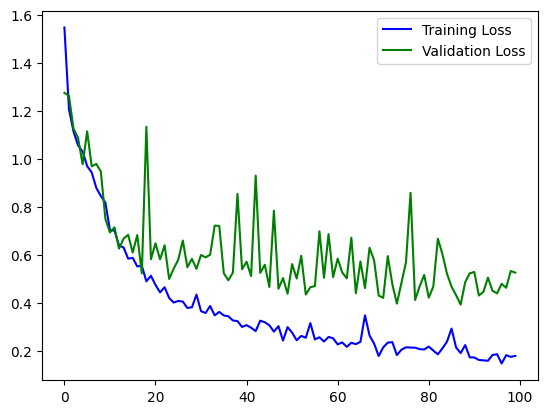

In [23]:
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'g-', label='Validation Loss')
plt.legend()
plt.show()

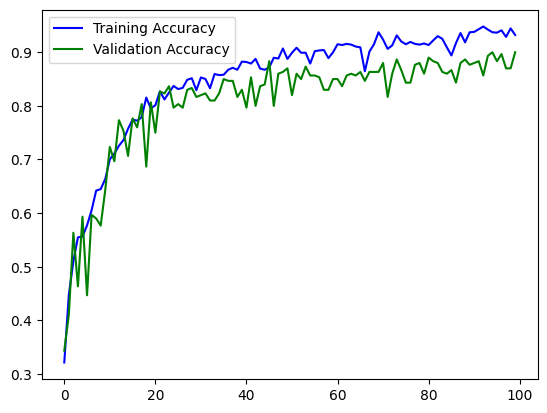

In [24]:
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
plt.legend()
plt.show()

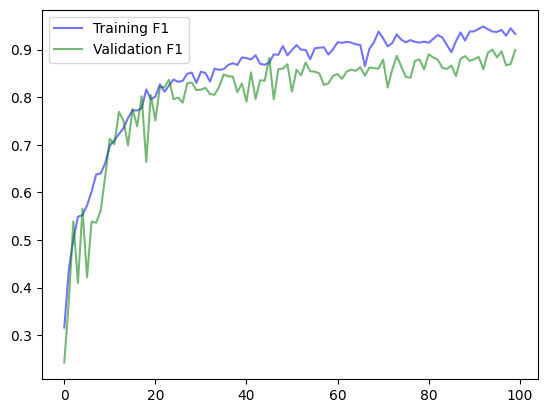

In [25]:
plt.plot(history.history['f1'], 'b-', label='Training F1', alpha=0.55)
plt.plot(history.history['val_f1'], 'g-', label='Validation F1', alpha=0.55)
plt.legend()
plt.show()

In [26]:
y_true, y_pred = [], []
for idx, (img, lab) in enumerate(val_datagen):
    y_true.extend(lab.argmax(1))
    pred = model.predict(img, verbose=0)
    y_pred.extend(pred.argmax(1))
    if idx == len(val_datagen)-1:
        break

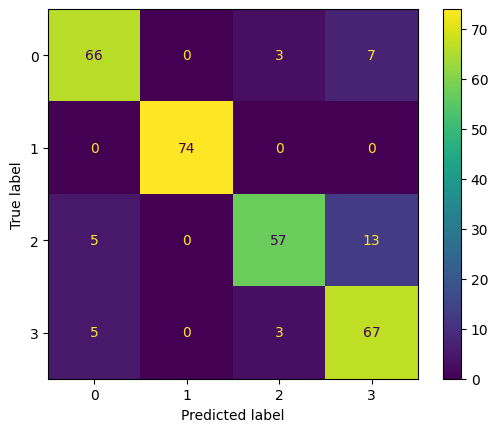

In [27]:
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred);

In [28]:
y_true, y_pred = [], []
for idx, (img, lab) in enumerate(test_datagen):
    y_true.extend(lab.argmax(1))
    pred = model.predict(img, verbose=0)
    y_pred.extend(pred.argmax(1))
    if idx == len(test_datagen)-1:
        break

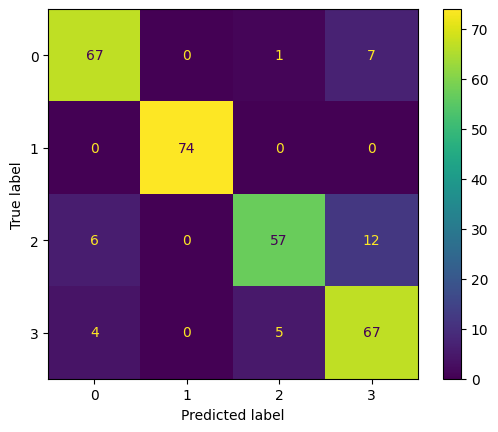

In [29]:
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred);

----

In [105]:
# https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [106]:
# model = tf.keras.models.load_model('alzheimers_detection_model_5.h5')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 221, 221, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 221, 221, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 108, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 107, 107, 64)   │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 107, 107, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 51, 51, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,571,142 (78.47 MB)

 Trainable params: 20,571,140 (78.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [110]:
imgs, labs = next(iter(test_datagen))

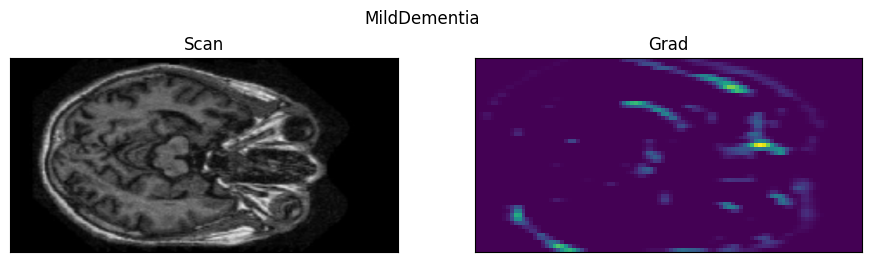

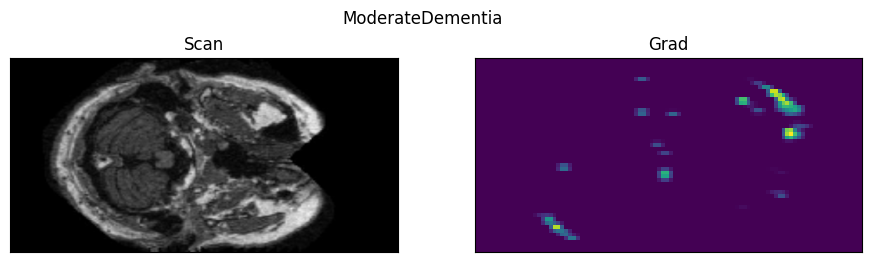

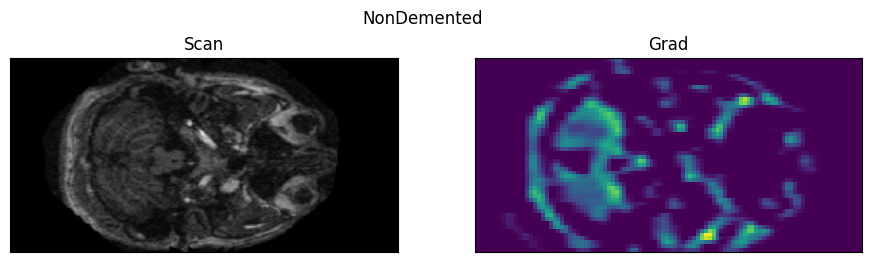

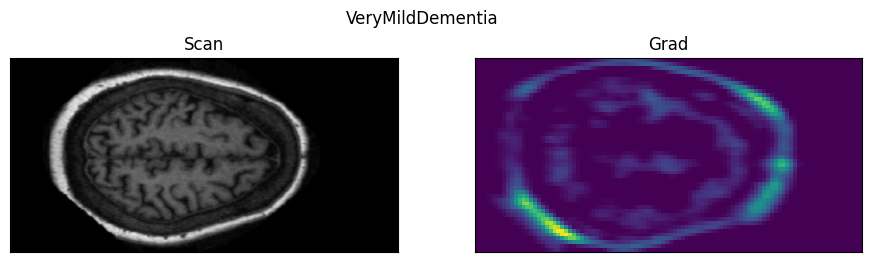

In [111]:
# layer = 'conv2d_4'
layer = 'conv2d_5'
for cls in range(len(classes)):
    idx = np.where(labs.argmax(1)==cls)[0][0]
    img = imgs[idx:idx+1,:,:,:]
    pred = model.predict(img, verbose=0)
    heatmap = make_gradcam_heatmap(img, model, layer)
    
    img = tf.image.resize(img, (248, 496))[0,:,:,:]
    heatmap = tf.image.resize(np.expand_dims(heatmap, -1), (heatmap.shape[0], heatmap.shape[1]*2))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
    axes[0].imshow(img)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Scan')
    axes[1].imshow(heatmap)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Grad')
    fig.suptitle(classes[cls])
    plt.show()

---

In [117]:
import shap

/Users/williamarliss/PyEnvs/stat6202/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [118]:
imgs, labs = next(iter(test_datagen))

In [119]:
masker = shap.maskers.Image("inpaint_telea", imgs.shape[1:])

In [120]:
explainer = shap.Explainer(model.__call__, masker, output_names=classes)

In [125]:
shap_values = explainer(imgs[:10,:,:,:], max_evals=100, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 11it [00:24,  4.04s/it]                                                                                                         


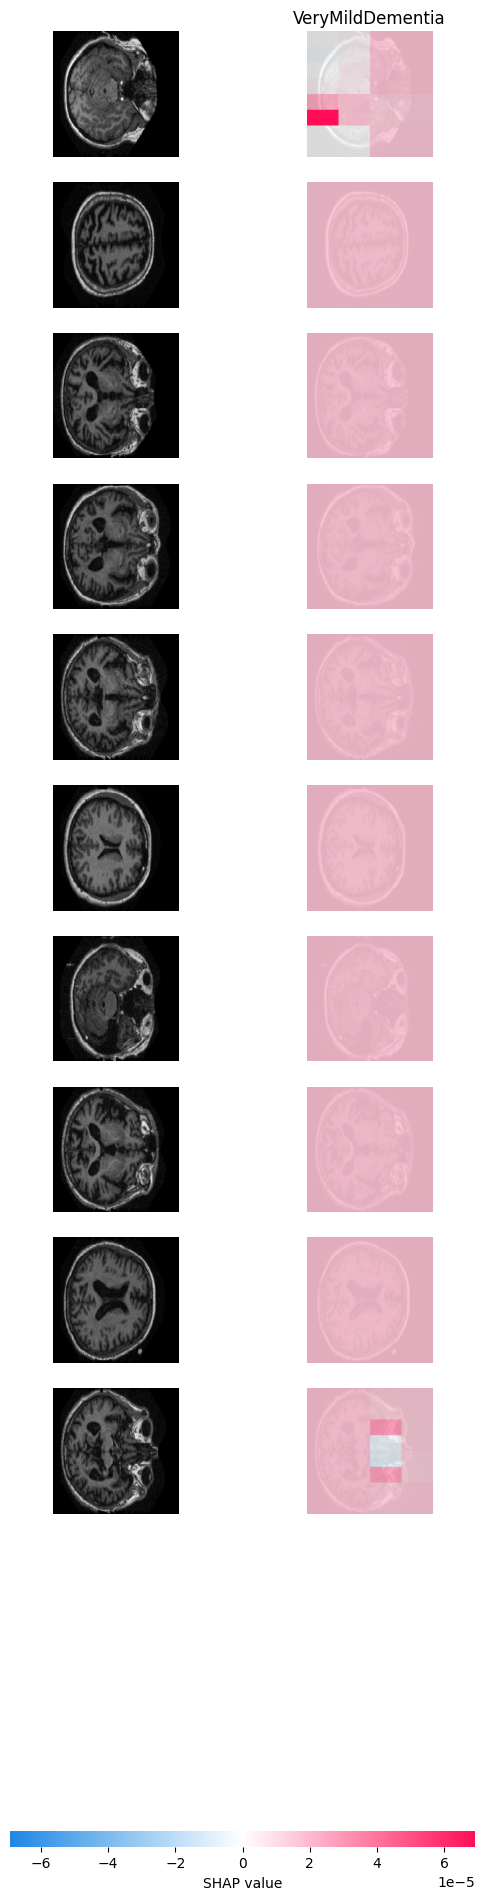

In [126]:
shap.image_plot(shap_values)

In [127]:
e = shap.GradientExplainer(model, imgs)

In [128]:
shap_values = e.shap_values(imgs)

/Users/williamarliss/PyEnvs/stat6202/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(12, 224, 224, 3))']
  warnings.warn(msg)
/Users/williamarliss/PyEnvs/stat6202/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


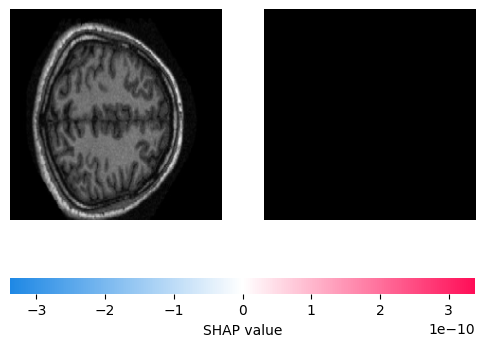

In [129]:
shap.image_plot(shap_values, img[:1], )

In [11]:
# # alzheimers_detection_model_1

# model = Sequential([

#     layers.Input(shape=(HEIGHT, WIDTH, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.25),
#     layers.Dense(len(classes), activation='softmax'),
    
# ])

In [12]:
# # alzheimers_detection_model_2

# model = Sequential([

#     layers.Input(shape=(HEIGHT, WIDTH, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(classes), activation='softmax'),
    
# ])

In [13]:
# # alzheimers_detection_model_3

# model = Sequential([

#     layers.Input(shape=(HEIGHT, WIDTH, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(classes), activation='softmax'),
    
# ])

In [14]:
# # alzheimers_detection_model_4 _5

# model = Sequential([

#     layers.Input(shape=(HEIGHT, WIDTH, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),

#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.25),
#     layers.Dense(len(classes), activation='softmax'),
    
# ])